# i22 Corrections

## Installation

To run this notebook locally, first clone the git repository and install the python dependencies as shown below:

```bash
    git clone https://github.com/garryod/adcorr.git
    cd adcorr
    pip install -e .[dev,docs] -r requirements.txt
```

Alternatively, you may wish to clone the repository and open the project in a container with Visual Studio Code and the Remote Containers extension (``ms-vscode-remote.remote-containers``).

## Import dependencies

In [1]:
from math import prod
from pathlib import Path

from h5py import File
from numpy import array, ones

from adcorr.corrections import mask_frames
from adcorr.sequences import pauw_dispersed_sample_sequence

from matplotlib.pyplot import imshow, subplots
from matplotlib.colors import LogNorm

## Download i22 tutorial dataset

In this tutorial we will use the PEG dataset included in the Diamond Light Source i22 Tutorial Dataset, hosted on zenodo: https://zenodo.org/record/2671750

Please download this file and extract it; Once complete please set the ``SAMPLE_PATH``, ``DISPERSANT_PATH`` and ``BACKGROUND_PATH`` to the locations of the ``i22-363095.nxs``, ``i22-363096.nxs`` and ``i22-363098.nxs`` files respectively.

The PEG dataset contains a series of NeXus files corresponding to individual experimental captures, by reading the ``entry1/title`` entry of each we can deduce that they have the following correspondence:

* ``i22-363095.nxs``: Empty capillary tube
* ``i22-363096.nxs``: Water in capillary tube
* ``i22-363098.nxs`` - ``i22-363107.nxs``: PEG in water (varying concentrations)

In [2]:
SAMPLE_PATH =  Path("/tmp/I22 Tutorial Dataset/I22 PEG Tutorial/i22-363105.nxs")
DISPERSANT_PATH = Path("/tmp/I22 Tutorial Dataset/I22 PEG Tutorial/i22-363096.nxs")
BACKGROUND_PATH = Path("/tmp/I22 Tutorial Dataset/I22 PEG Tutorial/i22-363095.nxs")

## Load required data from files

We shall now extract all available requisite data from the available NeXus files.

From each the sample, dispersant and background files we will load the following:

* Image stack, from ``entry1/Pilatus2M_WAXS/data``
* Count times, from ``entry1/instrument/Pilatus2M_WAXS/count_time``
* Incident flux, from ``entry1/I0/data``
* Transmitted flux, from ``entry1/It/data``

Additionally, we will extract the following data from solely the sample NeXus file:

* Pixel wise mask, from ``entry1/Pilatus2M_WAXS/pixel_mask``
* Beam center x & y, from ``entry1/instrument/Pilatus2M_WAXS/beam_center_x`` & ``entry1/instrument/Pilatus2M_WAXS/beam_center_y`` respectively
* Physical pixel sizes in x & y, from ``entry1/instrument/Pilatus2M_WAXS/x_pixel_size`` & ``entry1/instrument/Pilatus2M_WAXS/y_pixel_size`` respectively
* Distance between sample and detector, from ``entry1/instrument/Pilatus2M_WAXS/distance``
* Sample thickness, from ``entry1/sample/thickness``

In [3]:
with File(SAMPLE_PATH) as sample_file:
    print(f"Retrieving sample from {array(sample_file['entry1/title'])}")
    frames = array(sample_file["entry1/Pilatus2M_WAXS/data"])
    frames_count_times = array(sample_file["entry1/instrument/Pilatus2M_WAXS/count_time"])
    frames_incident_flux = array(sample_file["entry1/I0/data"])
    frames_transmitted_flux = array(sample_file["entry1/It/data"])

    mask = array(sample_file["entry1/Pilatus2M_WAXS/pixel_mask"])
    beam_center_x = array(sample_file["entry1/instrument/Pilatus2M_WAXS/beam_center_x"])
    beam_center_y = array(sample_file["entry1/instrument/Pilatus2M_WAXS/beam_center_y"])
    x_pixel_size = array(sample_file["entry1/instrument/Pilatus2M_WAXS/x_pixel_size"])
    y_pixel_size = array(sample_file["entry1/instrument/Pilatus2M_WAXS/y_pixel_size"])
    sample_detector_separation = array(sample_file["entry1/instrument/Pilatus2M_WAXS/distance"])
    sample_thickness = array(sample_file["entry1/sample/thickness"])

with File(DISPERSANT_PATH) as dispersant_file:
    print(f"Retrieving dispersant from {array(dispersant_file['entry1/title'])}")
    dispersants = array(dispersant_file["entry1/Pilatus2M_WAXS/data"])
    dispersants_count_times = array(dispersant_file["entry1/instrument/Pilatus2M_WAXS/count_time"])
    dispersants_incident_flux = array(dispersant_file["entry1/I0/data"])
    dispersants_transmitted_flux = array(dispersant_file["entry1/It/data"])

with File(BACKGROUND_PATH) as background_file:
    print(f"Retrieving background from {array(background_file['entry1/title'])}")
    backgrounds = array(background_file["entry1/Pilatus2M_WAXS/data"])
    backgrounds_count_times = array(background_file["entry1/instrument/Pilatus2M_WAXS/count_time"])
    backgrounds_incident_flux = array(background_file["entry1/I0/data"])
    backgrounds_transmitted_flux = array(background_file["entry1/It/data"])

Retrieving sample from b'PEG in water (80:20 v/v)'


Retrieving dispersant from b'Water in capillary tube'


Retrieving background from b'Empty capillary tube'


## Prepare data for processing

### Re-shape & scale loaded data

Prior to correction, we must re-shape and scale the loaded data to fit out requisite dimensionality and units.

For each the sample, dispersant and background we will apply the following re-shaping:

* Image stacks will be reshaped to three dimensions (``NumFrames``, ``FrameWidth``, ``FrameHeight``)
* Count times will be flattened to a one dimensional array
* Incident flux will be flattened to a one dimensional array
* Transmitted flux will be flattened to a one dimensional array

Additionally, we will extract the singular value in each the beam center, pixel size and thickness arrays and convert them to a scalar value.

Finally, we will perform the following scaling:

* Incident flux will be scaled from milli-counts to counts
* Transmitted flux will be scaled from micro-counts to counts
* Sample thickness will be scaled from milli-metres to metres

In [4]:
frames = frames.reshape(prod(frames.shape[:-2]), *frames.shape[-2:])
frames_count_times = frames_count_times.flatten()
frames_incident_flux = frames_incident_flux.flatten() * 1e-3
frames_transmitted_flux = frames_transmitted_flux.flatten() * 1e-6

dispersants = dispersants.reshape(prod(dispersants.shape[:-2]), *dispersants.shape[-2:])
dispersants_count_times = dispersants_count_times.flatten()
dispersants_incident_flux = dispersants_incident_flux.flatten() * 1e-3
dispersants_transmitted_flux = dispersants_transmitted_flux.flatten() * 1e-6

backgrounds = backgrounds.reshape(prod(backgrounds.shape[:-2]), *backgrounds.shape[-2:])
backgrounds_count_times = backgrounds_count_times.flatten()
backgrounds_incident_flux = backgrounds_incident_flux.flatten() * 1e-3
backgrounds_transmitted_flux = backgrounds_transmitted_flux.flatten() * 1e-6

beam_center_pixels = (
    beam_center_y.item(),
    beam_center_x.item()
)
pixel_sizes = (
    x_pixel_size.item(),
    y_pixel_size.item()
)
sample_thickness = sample_thickness.item() * 1e-3

### Add additional fields

Several required fields are not available from the downloaded datasets, as such we will have to provide constants, as follows:

* ``FLATFIELD`` is assigned a uniform field of ones, as flatfield correction has been applied by the detector
* ``MINIMUM_PULSE_SEPARATION`` is assigned a value of 2μs, this is typical for a photon counting detector
* ``MINIMUM_ARRIVAL_SEPARATION`` is assigned a value of 3μs, this is typical for a photon counting detector
* ``BASE_DARK_CURRENT`` is assigned a value of zero, as we have no information on it
* ``TEMPORAL_DARK_CURRENT`` is assigned a value of zero, as we have no information on it
* ``FLUX_DEPENDANT_DARK_CURRENT`` is assigned a value of zero, as we have no information on it
* ``SENSOR_ABSORPTION_COEFFICIENT`` is assigned a value of 0.85, this is typical for a silicone based sensor
* ``SENSOR_THICKNESS`` is assigned a value of 1mm, this is typical for a silicone based photon counting detector
* ``BEAM_POLARIZATION`` is assigned a value of 0.5, representing unpolarized light
* ``DISPLACED_FRACTION`` is assigned a value of 0.8, as shown in the ``entry1/title`` field of the sample file



In [5]:
FLATFIELD = ones(frames.shape[-2:])
MINIMUM_PULSE_SEPARATION = 2e-6
MINIMUM_ARRIVAL_SEPARATION = 3e-6
BASE_DARK_CURRENT = 0.0
TEMPORAL_DARK_CURRENT = 0.0
FLUX_DEPENDANT_DARK_CURRENT = 0.0
SENSOR_ABSORPTION_COEFFICIENT = 0.85
SENSOR_THICKNESS = 1e-3
BEAM_POLARIZATION = 0.5
DISPLACED_FRACTION = 0.8

## Visualize raw data

As a sanity check, we will visualize the first image from the images stack of each the sample, dispersant and background datasets, with the pixelwise mask applied.

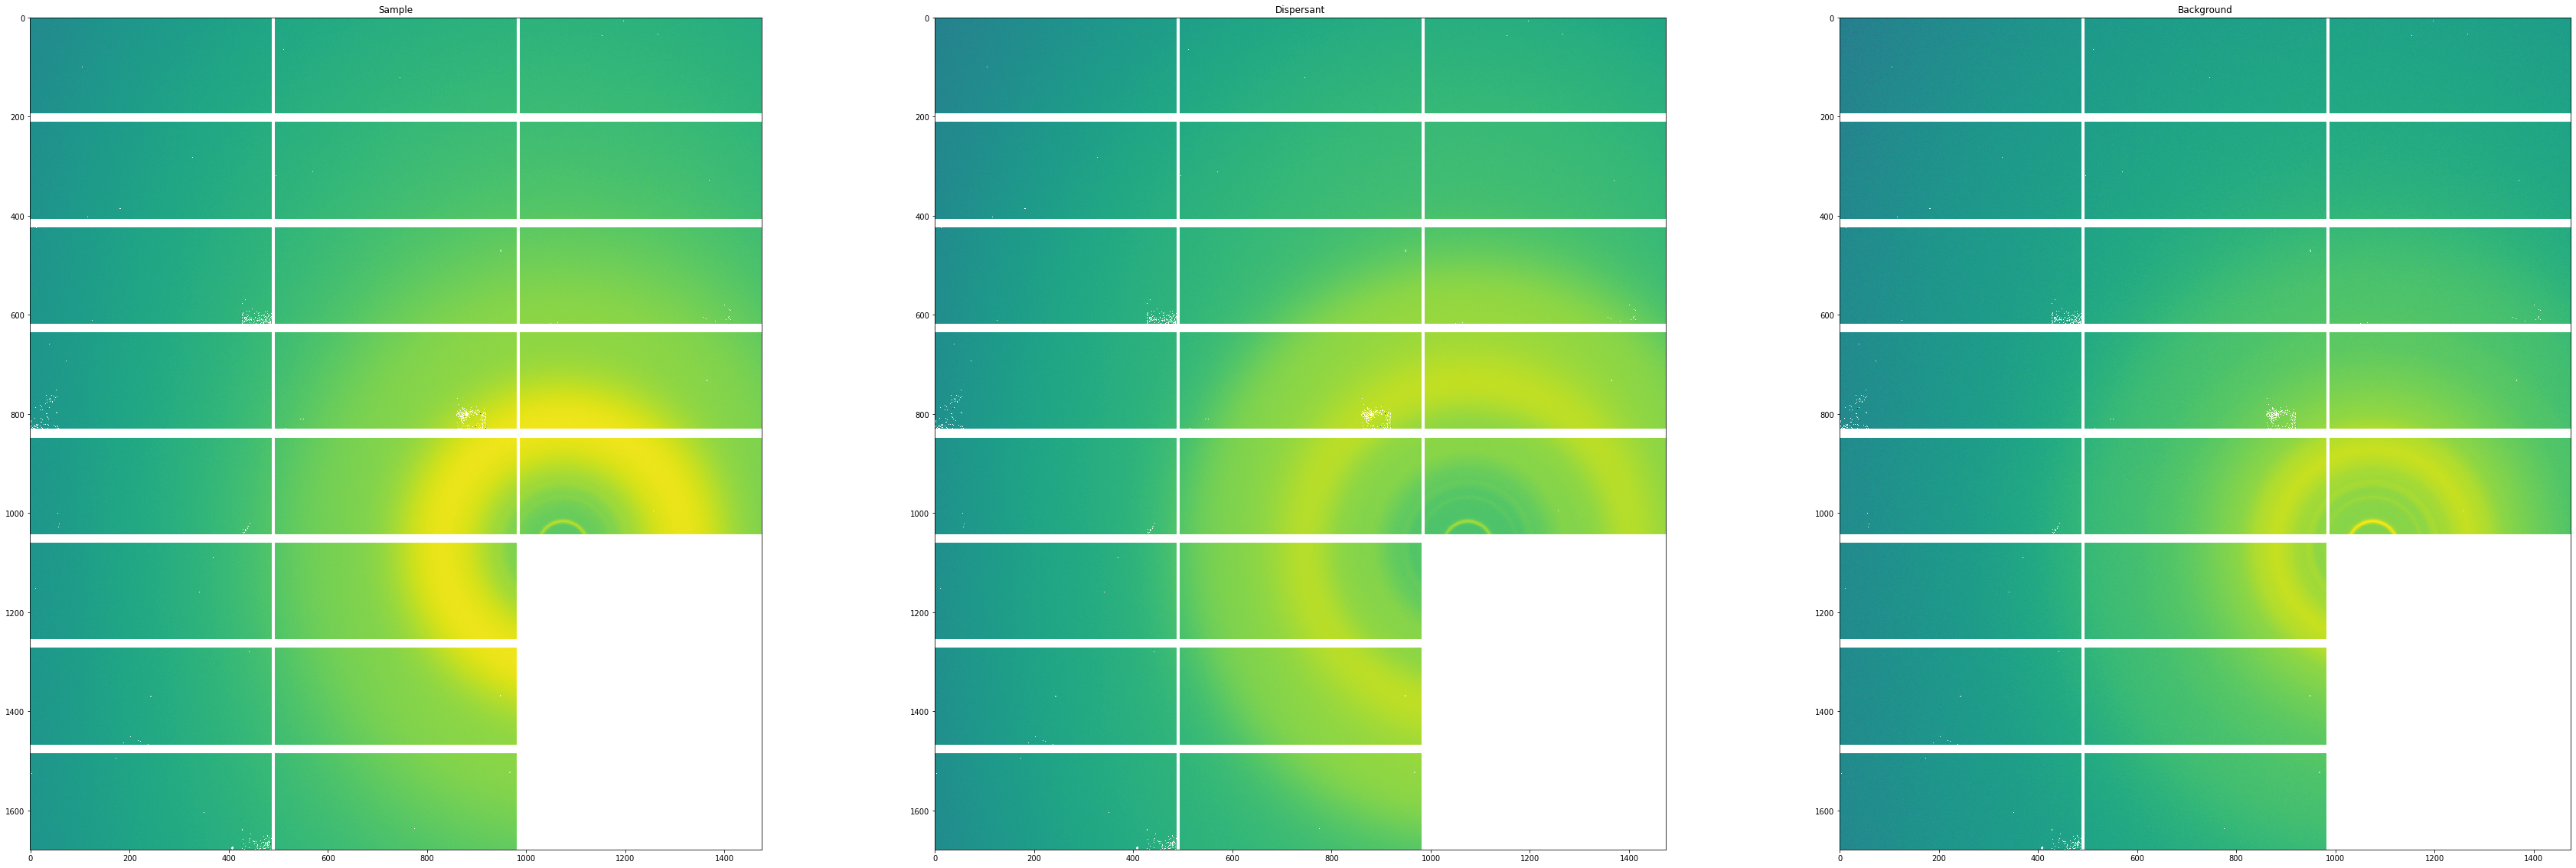

In [6]:
fig, axes = subplots(1, 3)
fig.set_size_inches(60,20)
axes[0].imshow(mask_frames(frames, mask)[0], norm=LogNorm(), interpolation="none")
axes[0].title.set_text("Sample")
axes[1].imshow(mask_frames(dispersants, mask)[0], norm=LogNorm(), interpolation="none")
axes[1].title.set_text("Dispersant")
axes[2].imshow(mask_frames(backgrounds, mask)[0], norm=LogNorm(), interpolation="none")
axes[2].title.set_text("Background")

## Correct data using Pauw dispersed sample sequence

We will now apply the dispersed sample data correction sequence described by Pauw et al. (2017) [https://doi.org/10.1107/S1600576717015096] by calling the ``pauw_dispersed_sample_sequence`` with all requisite parameters. The resultant corrected images will be stored in the ``corrected_frames`` variable for subsequent visualization.

In [7]:
corrected_frames = pauw_dispersed_sample_sequence(
    frames,
    dispersants,
    backgrounds,
    mask,
    FLATFIELD,
    frames_count_times,
    dispersants_count_times,
    backgrounds_count_times,
    frames_incident_flux,
    frames_transmitted_flux,
    dispersants_incident_flux,
    dispersants_transmitted_flux,
    backgrounds_incident_flux,
    backgrounds_transmitted_flux,
    MINIMUM_PULSE_SEPARATION,
    MINIMUM_ARRIVAL_SEPARATION,
    BASE_DARK_CURRENT,
    TEMPORAL_DARK_CURRENT,
    FLUX_DEPENDANT_DARK_CURRENT,
    beam_center_pixels,
    pixel_sizes,
    sample_detector_separation,
    SENSOR_ABSORPTION_COEFFICIENT,
    sample_thickness,
    SENSOR_THICKNESS,
    BEAM_POLARIZATION,
    DISPLACED_FRACTION,
)

# Visualize corrected data

Finally, we will visualize both the first image of the uncorrected sample image stack beside the first image of the corrected image stack. As you can see, several artifacts due to the beam are removed including most notably the small Kapton ring near the beam center.

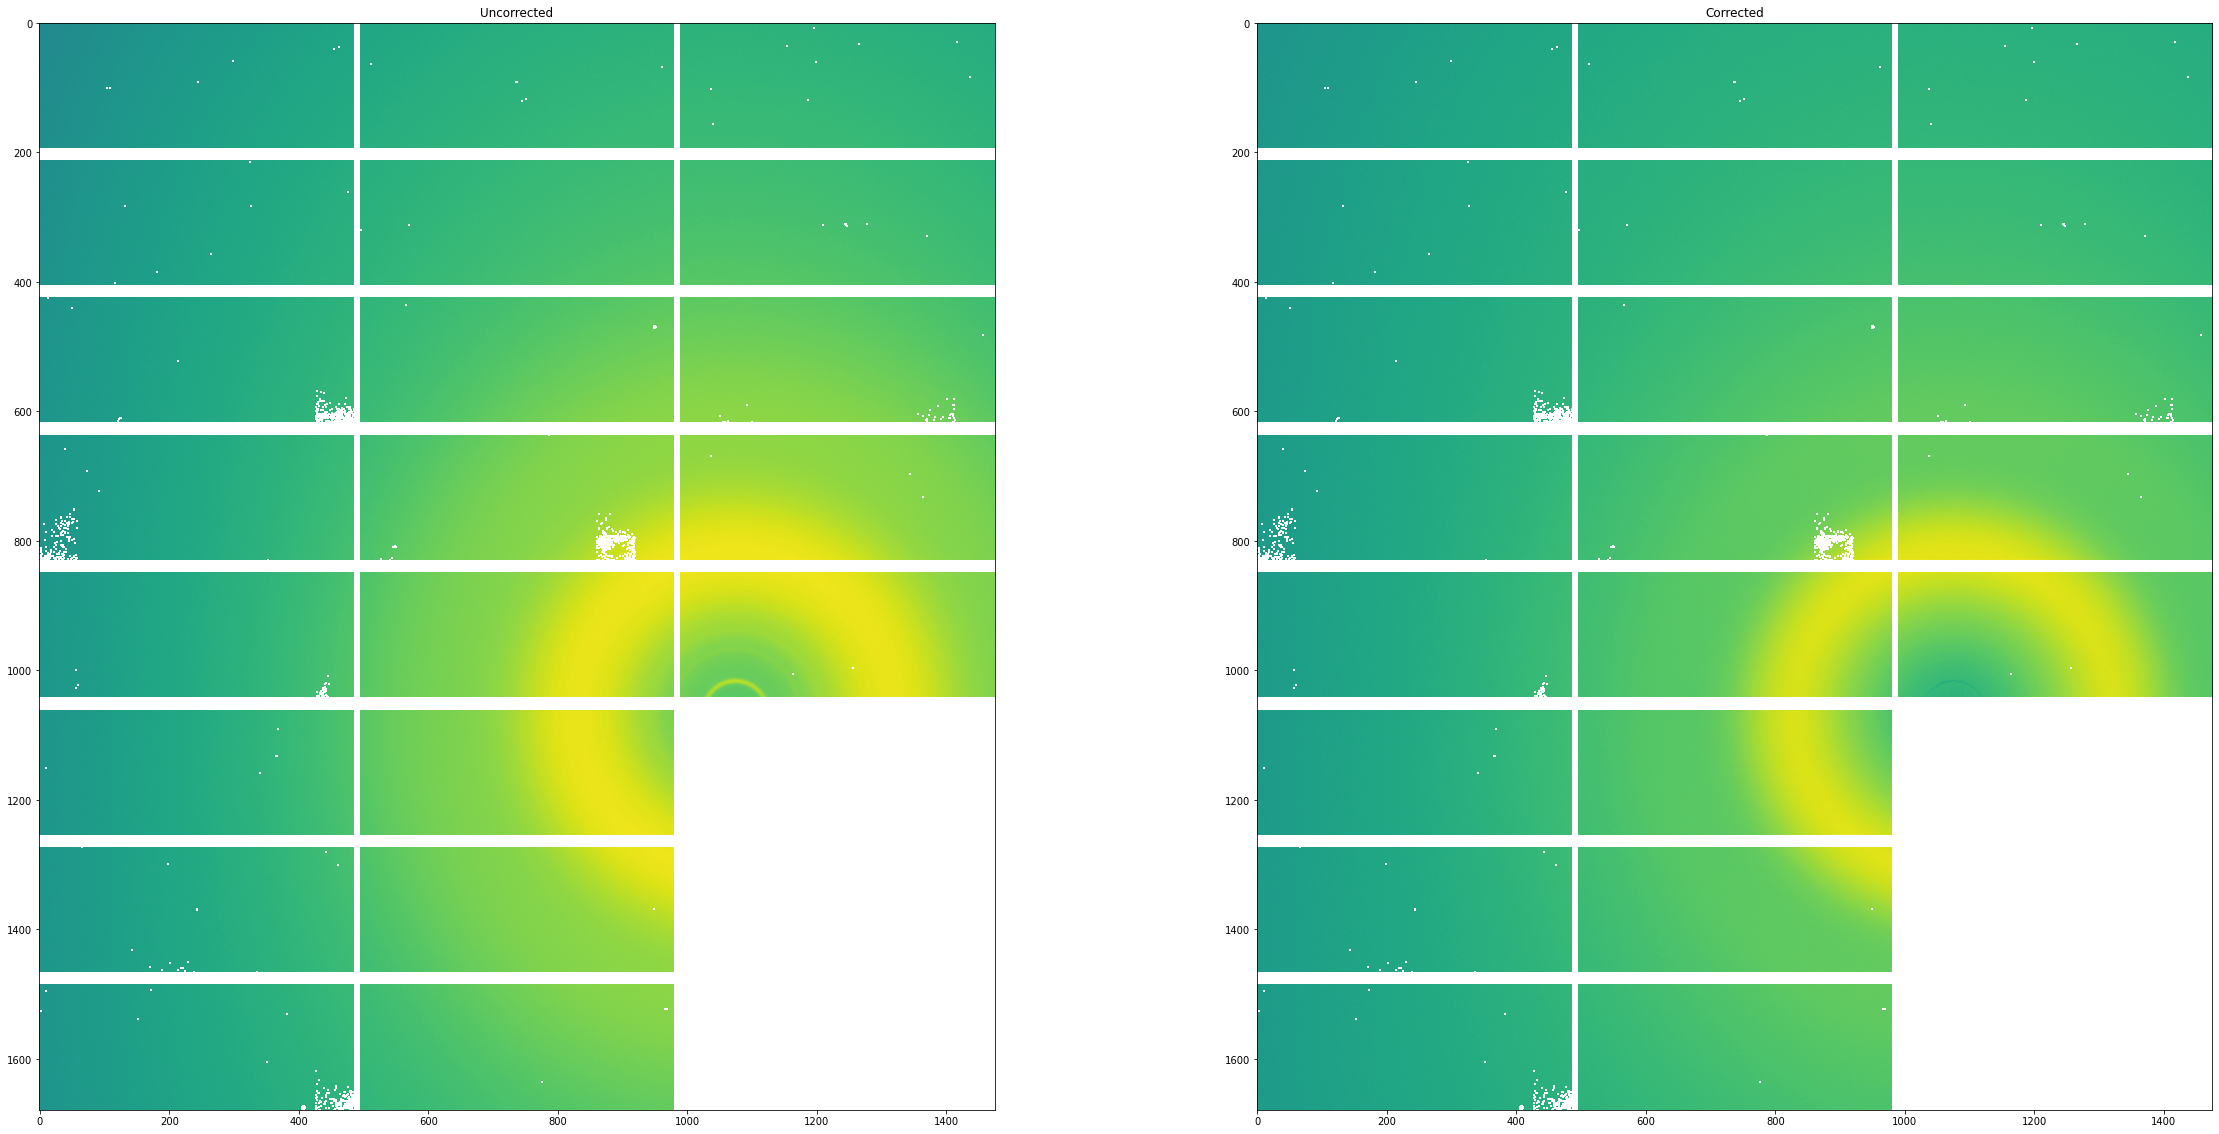

In [8]:
fig, axes = subplots(1, 2)
fig.set_size_inches(40,20)
axes[0].imshow(mask_frames(frames, mask)[0], norm=LogNorm())
axes[0].title.set_text("Uncorrected")
axes[1].imshow(corrected_frames[0], norm=LogNorm())
axes[1].title.set_text("Corrected")